In [470]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [471]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from enum import IntEnum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import trange
from collections import defaultdict

from GrU_nn import (gru_module_1, gru_module_2, gru_module_3, gru_module_4, neuralGrU)
from GrU import (evaluate, GrU, getBestExporter, getCost)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

### Load auction data

In [472]:
class clock( IntEnum ):
    pv = 0
    storage = 1
    charge = 2
    discharge = 3

class source( IntEnum ):
    grid =  0
    pv = 1
    storage = 2
    charge = 3
    discharge = 4

df_auctioneer_data = pd.read_csv('../data/Auctioneer Data.csv')

headers = np.load(file='../data/clock_data_columns.npy', allow_pickle=True)
df_clock_data = pd.DataFrame(np.load('../data/clock_data_values.npy', allow_pickle=True), columns=headers)

def getPriceVectors(round):
    '''
    Get price vectors for a round from the clock data.

    Parameters
    ----------
    round : int
        Round number to get the price vectors for, range = [0, 308]

    Returns
    -------
    prices : ndarray of shape (5, 24)
        Price vectors for g, p, s, c, d.
    
    '''
    prices = np.ndarray((5, 24))
    prices[0] = df_auctioneer_data.GRID_PRICE.values
    for e in clock:
        prices[e + 1] = df_clock_data[f'price_{round}'][e]
    return prices

## Revenue Maximisation

In [473]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [639]:
# Init model
eta = 1
scaler = 1
ep = np.ones(24)

model = neuralGrU(B=64, n_agents=1, ep=ep, gamma=[0], eta_c=eta, eta_d=eta, alpha=1e3).to(device)

#### Input Data

In [640]:
# # Price vectors sampled from Normal Distribution(mu=0, sigma=1)
# prices = np.abs(np.random.normal(loc=0, scale=1, size=(5, 24))) * scaler

> Hyperparameters: lr = 0.125, gamma = 0.94, B = 5, scaler = 1, Curriculum Learning & ExponentialLR Scheduler

In [641]:
# Price vectors sampled from Uniform Distribution [0, 1)
prices = np.random.random(size=(5, 24)) * scaler

> Hyperparameters: lr = 0.1, gamma = 0.94, B = 5, scaler = 1, Curriculum Learning & ExponentialLR Scheduler

In [642]:
# # Price vectors from Auction Data
# prices = getPriceVectors(300) * scaler

> Hyperparameters: lr = 1, gamma = 0.92, B = 1, scaler = 1 Curriculum Learning & ExponentialLR Scheduler

In [643]:
# Total demand tensor (Unit)
d_t = torch.ones((1, 24), requires_grad=False, device=device) * 5
# d_t = torch.ones(24, requires_grad=False, device=device)

# Cap tensor
C_p = torch.ones((1, 24), requires_grad=False) * 4
# C_d = torch.ones((1, 24), requires_grad=False) * 4

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

#### Optimisation schedule

In [ ]:
# Hyperparameter(s)
learning_rate = 0.0075
epochs = 500

history = []
best_loss = 0

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t, C_p)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star.squeeze())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss / scaler)

    if loss < best_loss:
        pi_optimal, best_loss = [], loss
        for pi in pi_p, pi_s, pi_c, pi_d:
            pi_optimal.append(pi.clone().detach())

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

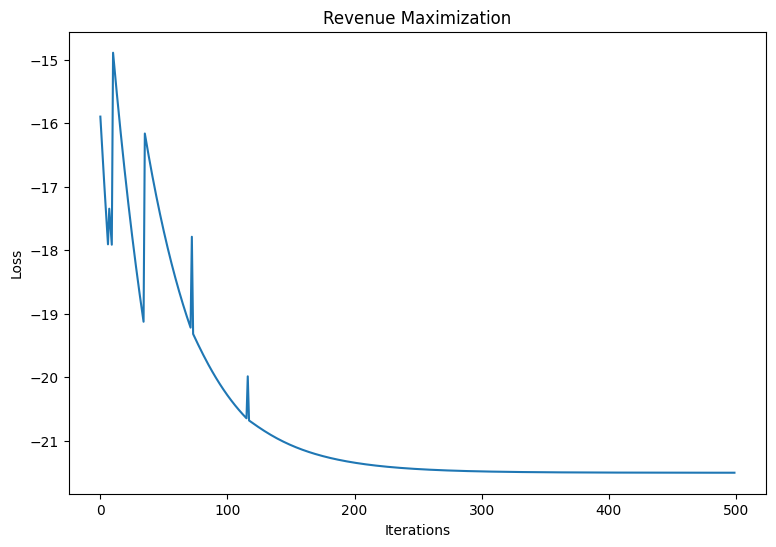

In [601]:
plt.figure(figsize=(9,6))
plt.plot(history, label='loss')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [602]:
best_loss, loss

(-21.50415185975394, -21.50415185975394)

In [566]:
pi_optimal

[tensor([0.9363, 0.4613, 0.3750, 0.7708, 0.4697, 0.4501, 0.3337, 0.9813, 0.7533,
         0.9588, 0.6983, 0.7986, 0.7071, 0.6883, 0.4358, 0.2390, 0.7296, 0.7033,
         0.7663, 0.9332, 0.4057, 0.8155, 0.1097, 0.7467], dtype=torch.float64),
 tensor([3.1653e-01, 5.4161e-01, 5.3746e-01, 3.9659e-01, 3.1644e-01, 7.7085e-04,
         8.7985e-01, 6.4841e-01, 2.6490e-01, 4.7361e-01, 7.3113e-01, 7.6855e-02,
         1.6971e-01, 5.9411e-01, 8.9218e-01, 6.5400e-01, 8.8680e-01, 1.2364e-01,
         6.0088e-01, 3.5673e-02, 2.7365e-01, 5.2129e-01, 3.8024e-01, 8.7176e-01],
        dtype=torch.float64),
 tensor([0.5264, 0.1014, 0.8595, 0.3664, 0.9816, 0.9985, 0.0610, 0.9407, 0.2141,
         0.5294, 0.4727, 0.6075, 0.0356, 0.9216, 0.5652, 0.4809, 0.9372, 0.2600,
         0.2807, 0.9693, 0.8226, 0.4648, 0.2323, 0.9134], dtype=torch.float64),
 tensor([0.3443, 0.5949, 0.1881, 0.9733, 0.0678, 0.9060, 0.4355, 0.8010, 0.0244,
         0.5526, 0.6724, 0.0386, 0.2510, 0.7083, 0.2083, 0.1172, 0.1127, 0.8820,

In [603]:
torch.round(pi_g - pi_p, decimals=2)

tensor([-0.2700,  0.4200, -0.1700, -0.7400,  0.3200, -0.1000,  0.4100, -0.3800,
        -0.5700,  0.0100, -0.0500, -0.2200,  0.0100,  0.0000, -0.1500, -0.0100,
        -0.5400,  0.1000, -0.0300, -0.8000,  0.4000, -0.1600, -0.0500, -0.5800],
       dtype=torch.float64, grad_fn=<RoundBackward1>)

In [567]:
torch.round(pi_g - pi_optimal[0], decimals=2)

tensor([-0.2700,  0.5200, -0.1400, -0.7400,  0.4200, -0.0600,  0.5100, -0.3800,
        -0.5700,  0.0100, -0.0000, -0.2200,  0.0600,  0.1000, -0.1100,  0.0000,
        -0.5400,  0.2000,  0.0100, -0.8000,  0.5000, -0.1100,  0.0100, -0.5800],
       dtype=torch.float64)

In [604]:
torch.round(d_star, decimals=2)

tensor([[[5., 1., 5., 5., 1., 5., 1., 5., 5., 1., 5., 5., 1., 1., 5., 5., 5.,
          1., 5., 5., 1., 5., 5., 5.],
         [0., 4., 0., 0., 4., 0., 4., 0., 0., 4., 0., 0., 4., 4., 0., 0., 0.,
          4., 0., 0., 4., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64,
       grad_fn=<RoundBackward1>)

In [555]:
pi_p, pi_s, pi_c, pi_d = pi_optimal
model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t, C_p).round(decimals=3)

tensor([[[5., 1., 5., 1., 5., 1., 5., 5., 5., 5., 1., 1., 5., 1., 5., 1., 5.,
          5., 5., 5., 1., 1., 5., 5.],
         [0., 4., 0., 4., 0., 4., 0., 0., 0., 0., 4., 4., 0., 4., 0., 4., 0.,
          0., 0., 0., 4., 4., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64,
       grad_fn=<RoundBackward1>)

#### Demand breakup on optimised prices

In [336]:
pi = torch.stack([pi_g, pi_p, pi_s, pi_c, pi_d]).detach().numpy()

In [337]:
d_break_nn = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t).detach().numpy()
d_break, _ = GrU(d_t, pi, eta_c=eta, eta_d=eta)

In [338]:
evaluate(d_break, d_break_nn)[0]

[1.0186518295540736e-11, 1.0186483285313914e-11, 0.0, 0.0, 0.0]

In [339]:
d_break

array([[10.,  0., 10., 10., 10., 10.,  0.,  0., 10., 10., 10., 10., 10.,
         0., 10.,  0., 10.,  0., 10.,  0.,  0.,  0.,  0., 10.],
       [ 0., 10.,  0.,  0.,  0.,  0., 10., 10.,  0.,  0.,  0.,  0.,  0.,
        10.,  0., 10.,  0., 10.,  0., 10., 10., 10., 10.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## Multi-agent Revenue Maximization

In [660]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev


def barrier_loss(C_g, C, epsilon):
    '''
    Barrier function with barrier at C_g & sensitivity epsilon
    '''
    b = F.relu(-torch.log((C_g - C)/epsilon))

    return torch.sum(b)

In [661]:
eta = 1
n_agents = 5
gamma = [1, 2, 3, 4, 5]

# EI values
ep = [0.00044688, 0.00044796, 0.00045042, 0.00045573, 0.00046029, 0.00046002, 0.00045153, 0.00043737, 0.00042772, 0.00041107, 0.00040774, 0.00038668, 0.00037268, 0.00036565, 0.00036387, 0.00035763, 0.00034319, 0.00034377, 0.00035285, 0.00037902, 0.00039631, 0.00040366, 0.00039713, 0.00039088]
ep_t = np.array(ep) * 1e3

model = neuralGrU(
    B=64,
    n_agents=n_agents,
    ep=ep_t,
    gamma=gamma,
    device=device,
    eta_c=eta,
    eta_d=eta,
    alpha=1e3
)

In [681]:
prices = np.random.random((5, 24))

# Total demand tensor
d_t_n = torch.ones((n_agents, 24), requires_grad=False, device=device) * 2

# Global constraint
C_global = torch.ones(24, requires_grad=False, device=device) * 8

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv], requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

# Local constraints
C_t_n = torch.ones(size=(n_agents, 24), requires_grad=True, device=device)

In [682]:
# Hyperparameter(s)
learning_rate = 0.01
epochs = 500
epsilon = 0.25
nan = 1e3

history = []

optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d, C_t_n], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

for t in trange(epochs):
    d_star_n = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t_n, C_t_n)
    d_total = torch.sum(d_star_n, dim=0)
    C_total = torch.sum(C_t_n, dim=0)

    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_total) + barrier_loss(C_global, C_total, epsilon)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss)

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

100%|██████████| 500/500 [00:04<00:00, 113.87it/s]


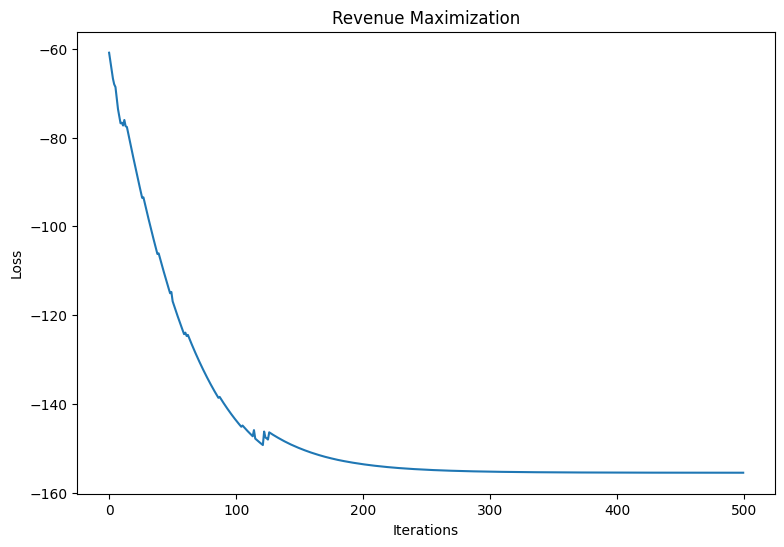

In [683]:
plt.figure(figsize=(9,6))
plt.plot(history)
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [689]:
pi_p

tensor([0.7605, 0.6377, 0.9417, 0.8691, 1.1374, 0.6055, 1.1751, 1.0905, 1.1391,
        0.7864, 0.8296, 1.4311, 0.9143, 1.1820, 0.9554, 0.8452, 1.4830, 0.5382,
        1.2708, 1.2940, 0.7308, 0.7540, 0.9408, 0.5570], dtype=torch.float64,
       requires_grad=True)

In [691]:
(torch.tensor(ep_t) * gamma[1] + pi_g - pi_p).round(decimals=2)

tensor([ 0.9700,  0.8100,  0.6800,  0.9800,  0.5700,  0.4900, -0.2300,  0.7100,
         0.4300,  0.4200,  0.7300,  0.0900,  0.5000, -0.0100,  0.0200,  0.2100,
        -0.0400,  0.2600,  0.3800,  0.4400,  0.9000,  0.9400, -0.1500,  0.5200],
       dtype=torch.float64, grad_fn=<RoundBackward1>)

### Local PV Constraint

In [684]:
C_t_n

tensor([[1.5500, 1.5500, 1.5473, 1.5500, 1.5369, 1.4953, 1.0000, 1.3694, 1.5331,
         1.5495, 1.5500, 1.2641, 1.5492, 1.1734, 1.0000, 1.4119, 1.1873, 1.4902,
         1.3527, 1.5314, 1.5500, 1.5500, 1.0000, 1.5500],
        [1.5500, 1.5500, 1.5473, 1.5500, 1.5369, 1.4982, 1.3218, 1.3694, 1.5338,
         1.5501, 1.5500, 1.5264, 1.5492, 1.4961, 1.5230, 1.5528, 1.4865, 1.5650,
         1.4324, 1.5314, 1.5500, 1.5500, 1.4014, 1.5500],
        [1.5500, 1.5500, 1.5473, 1.5500, 1.5369, 1.4982, 1.5333, 1.3859, 1.5338,
         1.5501, 1.5500, 1.5264, 1.5492, 1.5321, 1.5251, 1.5528, 1.5252, 1.5650,
         1.4974, 1.5314, 1.5500, 1.5500, 1.5452, 1.5500],
        [1.5500, 1.5500, 1.5473, 1.5500, 1.5369, 1.4982, 1.5333, 1.4026, 1.5338,
         1.5501, 1.5500, 1.5264, 1.5492, 1.5321, 1.5251, 1.5528, 1.5252, 1.5650,
         1.4660, 1.5314, 1.5500, 1.5500, 1.5452, 1.5500],
        [1.5500, 1.5500, 1.5473, 1.5500, 1.5369, 1.4982, 1.5333, 1.4026, 1.5338,
         1.5501, 1.5500, 1.5264, 1.5492

In [688]:
torch.sum(C_t_n, dim=0)

tensor([7.7500, 7.7500, 7.7363, 7.7500, 7.6846, 7.4882, 6.9217, 6.9299, 7.6683,
        7.7500, 7.7500, 7.3697, 7.7459, 7.2656, 7.0985, 7.6231, 7.2493, 7.7500,
        7.2145, 7.6571, 7.7500, 7.7500, 7.0368, 7.7500],
       grad_fn=<SumBackward1>)

### Total PV demand of all agents

In [693]:
torch.sum(d_star_n[:, 1], dim=0)

tensor([7.7500, 7.7500, 7.7363, 7.7500, 7.6846, 7.4882, 4.5999, 6.9299, 7.6683,
        7.7500, 7.7500, 6.1056, 7.7459, 4.5962, 6.0985, 6.2112, 4.5755, 6.2598,
        5.8619, 7.6571, 7.7500, 7.7500, 4.6355, 7.7500], dtype=torch.float64,
       grad_fn=<SumBackward1>)

In [701]:
torch.round(d_star_n[:, 1], decimals=2)

tensor([[1.5500, 1.5500, 1.5500, 1.5500, 1.5400, 1.5000, 0.0000, 1.3700, 1.5300,
         1.5500, 1.5500, 0.0000, 1.5500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.5300, 1.5500, 1.5500, 0.0000, 1.5500],
        [1.5500, 1.5500, 1.5500, 1.5500, 1.5400, 1.5000, 0.0000, 1.3700, 1.5300,
         1.5500, 1.5500, 1.5300, 1.5500, 0.0000, 1.5200, 1.5500, 0.0000, 1.5600,
         1.4300, 1.5300, 1.5500, 1.5500, 0.0000, 1.5500],
        [1.5500, 1.5500, 1.5500, 1.5500, 1.5400, 1.5000, 1.5300, 1.3900, 1.5300,
         1.5500, 1.5500, 1.5300, 1.5500, 1.5300, 1.5300, 1.5500, 1.5300, 1.5600,
         1.5000, 1.5300, 1.5500, 1.5500, 1.5500, 1.5500],
        [1.5500, 1.5500, 1.5500, 1.5500, 1.5400, 1.5000, 1.5300, 1.4000, 1.5300,
         1.5500, 1.5500, 1.5300, 1.5500, 1.5300, 1.5300, 1.5500, 1.5300, 1.5600,
         1.4700, 1.5300, 1.5500, 1.5500, 1.5500, 1.5500],
        [1.5500, 1.5500, 1.5500, 1.5500, 1.5400, 1.5000, 1.5300, 1.4000, 1.5300,
         1.5500, 1.5500, 1.5300, 1.5500

> PV demand of all 5 users

## Revenue Maximisation with Gradient Clipping

(Outdated code)

1. No Curriculum Learning (for B). Init B at 10-20.
2. Gradients clipped at 0, i.e., updates to price(s) are non-negative.
3. Input price tensors are scaled to compensate for lower B.
4. ExponentialLR performs better than ReduceLROnPlateau.

In [ ]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [ ]:
# Init model
eta = 1
B = 256
scaler = 1

model = neuralGrU(B, device, eta, eta).to(device)

#### Input Data

In [ ]:
# prices = getPriceVectors(100) * scaler
scaled_prices = prices * scaler

# Random total demand tensor
d_t = torch.ones(24, requires_grad=False, device=device)
# d_t = torch.ones(24, requires_grad=False, device=device)

# Price tensors
pi_g = torch.tensor(scaled_prices[source.grid] + grid_shift, requires_grad=False, device=device)

pi_p = torch.tensor(scaled_prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(scaled_prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(scaled_prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(scaled_prices[source.storage], requires_grad=True, device=device)

#### Optimization schedule

In [ ]:
# Hyperparameter(s)
learning_rate = 0.025
epochs = 500

history_grad_clip = []

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.982)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # Gradient Clipping
    for p in [pi_p, pi_s, pi_c, pi_d]:
        p.grad = -F.relu(-p.grad)

    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history_grad_clip.append(loss / scaler)

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 500/500 [00:03<00:00, 162.10it/s]


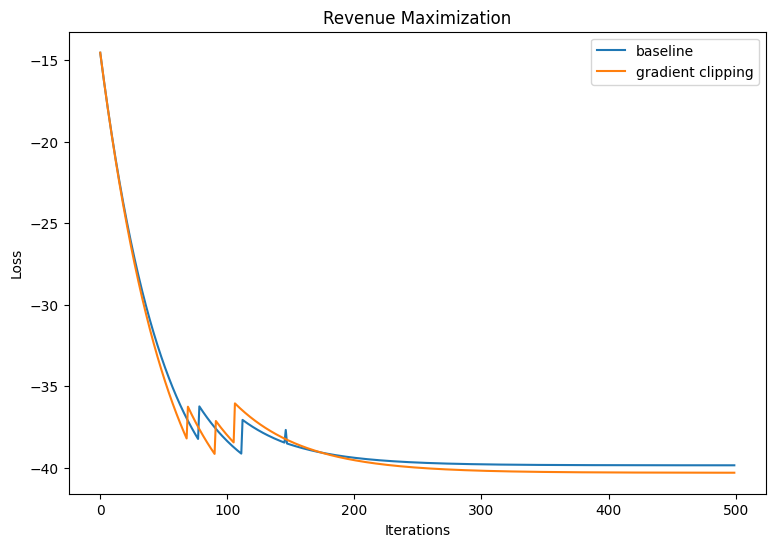

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(history, label='baseline')
plt.plot(history_grad_clip, label='gradient clipping')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
(pi_g > pi_p).all()

tensor(True)

In [ ]:
(pi_g - pi_p) / scaler

tensor([ 0.3661,  1.8690,  0.5150, -0.0408, -0.0312,  0.8866,  0.1038,  0.3904,
         1.3893,  0.8990,  0.1514,  1.9923,  0.6137,  0.7580,  0.5715,  0.3316,
         0.6517, -0.0619,  0.7804,  0.6153,  0.7038,  1.8420,  1.2148,  0.4223],
       dtype=torch.float64, grad_fn=<DivBackward0>)

In [ ]:
np.round(d_star.detach().numpy())

array([[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

## Rough work

### C_t_n reshape

In [371]:
# Rough

t = torch.randint(1, 10, (2, 5))
x = torch.randint(1, 10, (2, 5))
y = torch.randint(1, 10, (2, 5))

torch.stack([x.T, t.T, y.T]).T

tensor([[[9, 3, 4],
         [1, 4, 5],
         [6, 6, 3],
         [5, 9, 2],
         [8, 6, 5]],

        [[6, 3, 4],
         [4, 6, 6],
         [8, 1, 1],
         [3, 9, 8],
         [4, 7, 3]]])

In [372]:
x, t, y

(tensor([[9, 1, 6, 5, 8],
         [6, 4, 8, 3, 4]]),
 tensor([[3, 4, 6, 9, 6],
         [3, 6, 1, 9, 7]]),
 tensor([[4, 5, 3, 2, 5],
         [4, 6, 1, 8, 3]]))

### pi_g reshpae

In [385]:
pi = torch.randint(0, 10, (10,))
k = torch.tensor([10, 20, 30, 40, 50])

pi.expand(5, -1) * k.unsqueeze(dim=0).T

tensor([[ 90,  30,  30,  70,  80,  20,  60,  90,  40,  50],
        [180,  60,  60, 140, 160,  40, 120, 180,  80, 100],
        [270,  90,  90, 210, 240,  60, 180, 270, 120, 150],
        [360, 120, 120, 280, 320,  80, 240, 360, 160, 200],
        [450, 150, 150, 350, 400, 100, 300, 450, 200, 250]])

In [386]:
pi

tensor([9, 3, 3, 7, 8, 2, 6, 9, 4, 5])

In [404]:
a = torch.randint(0, 10, (3, 5, 5), dtype=int)
a

tensor([[[5, 1, 5, 7, 9],
         [7, 7, 2, 0, 0],
         [4, 2, 6, 9, 2],
         [3, 0, 7, 0, 3],
         [5, 7, 7, 0, 8]],

        [[6, 9, 0, 7, 5],
         [1, 1, 6, 9, 7],
         [7, 4, 3, 0, 9],
         [9, 1, 9, 7, 2],
         [9, 2, 9, 9, 4]],

        [[5, 0, 1, 7, 5],
         [7, 3, 8, 2, 4],
         [6, 2, 9, 3, 8],
         [0, 7, 4, 0, 6],
         [7, 9, 1, 1, 2]]])

In [405]:
a[:, 0, 0] = 100

In [406]:
a

tensor([[[100,   1,   5,   7,   9],
         [  7,   7,   2,   0,   0],
         [  4,   2,   6,   9,   2],
         [  3,   0,   7,   0,   3],
         [  5,   7,   7,   0,   8]],

        [[100,   9,   0,   7,   5],
         [  1,   1,   6,   9,   7],
         [  7,   4,   3,   0,   9],
         [  9,   1,   9,   7,   2],
         [  9,   2,   9,   9,   4]],

        [[100,   0,   1,   7,   5],
         [  7,   3,   8,   2,   4],
         [  6,   2,   9,   3,   8],
         [  0,   7,   4,   0,   6],
         [  7,   9,   1,   1,   2]]])

In [412]:
b = torch.tensor(np.random.rand(6, 5))
F.max_pool1d(b, kernel_size=5)

tensor([[0.7854],
        [0.6354],
        [0.6767],
        [0.8414],
        [0.6401],
        [0.8150],
        [0.5881],
        [0.8857],
        [0.9897],
        [0.8999]], dtype=torch.float64)

In [430]:
z = torch.tensor(np.random.rand(10, 2))
z

tensor([[0.7131, 0.7226],
        [0.2571, 0.3438],
        [0.8473, 0.1491],
        [0.2303, 0.4306],
        [0.1880, 0.4318],
        [0.3109, 0.1957],
        [0.3469, 0.9563],
        [0.5061, 0.7076],
        [0.4827, 0.9841],
        [0.9098, 0.2565]], dtype=torch.float64)

In [433]:
F.softmin(z, dim=1)

tensor([[0.5024, 0.4976],
        [0.5217, 0.4783],
        [0.3322, 0.6678],
        [0.5499, 0.4501],
        [0.5607, 0.4393],
        [0.4712, 0.5288],
        [0.6478, 0.3522],
        [0.5502, 0.4498],
        [0.6228, 0.3772],
        [0.3422, 0.6578]], dtype=torch.float64)

In [426]:
torch.sum(b[0])

tensor(1.8141, dtype=torch.float64)

In [427]:
torch.sum(b, dim=1)

tensor([1.8141, 1.0123, 2.3820, 2.3173, 2.3349, 1.8439, 1.5575, 2.8559, 3.1716,
        2.1116], dtype=torch.float64)

In [419]:
c = torch.ones((2, 5))

torch.cat([c, 2*c, 3*c], dim=1)

tensor([[1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3.],
        [1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3.]])

In [458]:
x = torch.ones((2, 5))
x[1, :] = 10

y = torch.stack([x, 2*x, 3*x], dim=2)
F.softmin(y, dim=2)

tensor([[[6.6524e-01, 2.4473e-01, 9.0031e-02],
         [6.6524e-01, 2.4473e-01, 9.0031e-02],
         [6.6524e-01, 2.4473e-01, 9.0031e-02],
         [6.6524e-01, 2.4473e-01, 9.0031e-02],
         [6.6524e-01, 2.4473e-01, 9.0031e-02]],

        [[9.9995e-01, 4.5398e-05, 2.0611e-09],
         [9.9995e-01, 4.5398e-05, 2.0611e-09],
         [9.9995e-01, 4.5398e-05, 2.0611e-09],
         [9.9995e-01, 4.5398e-05, 2.0611e-09],
         [9.9995e-01, 4.5398e-05, 2.0611e-09]]])

In [461]:
x = torch.ones(5)
y = torch.stack([x, 2*x, 3*x], dim=1)
z = F.softmin(y, dim=1)
t = z, z, z
t

(tensor([[0.6652, 0.2447, 0.0900],
         [0.6652, 0.2447, 0.0900],
         [0.6652, 0.2447, 0.0900],
         [0.6652, 0.2447, 0.0900],
         [0.6652, 0.2447, 0.0900]]),
 tensor([[0.6652, 0.2447, 0.0900],
         [0.6652, 0.2447, 0.0900],
         [0.6652, 0.2447, 0.0900],
         [0.6652, 0.2447, 0.0900],
         [0.6652, 0.2447, 0.0900]]),
 tensor([[0.6652, 0.2447, 0.0900],
         [0.6652, 0.2447, 0.0900],
         [0.6652, 0.2447, 0.0900],
         [0.6652, 0.2447, 0.0900],
         [0.6652, 0.2447, 0.0900]]))

In [468]:
torch.tril(torch.cumsum(torch.ones(5, 5), dim=1), diagonal=-1)

tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 2., 0., 0., 0.],
        [1., 2., 3., 0., 0.],
        [1., 2., 3., 4., 0.]])

In [469]:
z = torch.ones((2, 5, 5))
torch.tril(torch.cumsum(z, dim=2), diagonal=-1)

tensor([[[0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 2., 0., 0., 0.],
         [1., 2., 3., 0., 0.],
         [1., 2., 3., 4., 0.]],

        [[0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 2., 0., 0., 0.],
         [1., 2., 3., 0., 0.],
         [1., 2., 3., 4., 0.]]])

In [ ]:
a = torch.ones((5, 2))
a[0, 0] = 10
a[1, 0] = 8
a[2:, 1] = 5

b = torch.zeros((5, 24))

b[:, 2] = F.max_pool1d(a, kernel_size=2).T
b

tensor([[ 0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [ ]:
c = torch.zeros((5, 24, 24))

c[:, 2, :2] = F.softmax(a, dim=1)
c.round(decimals=2)[:, 2]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0200, 0.9800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0200, 0.9800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0200, 0.9800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000